# LLM Agent Collective Belief Formation Simulation
## Modified Version with Asynchronous Processing, Prompt-based Updates, and Flexible Network Topology

This notebook implements a simulation of LLM agents forming collective beliefs through conversations.

### Key Modifications:
1. **Asynchronous Parallel Processing**: Agents can have simultaneous conversations
2. **Prompt-based Belief Updates**: LLMs self-determine belief modifications
3. **Flexible Network Topology**: Support for random, fully connected, and custom networks

### Implementation Notes:
- The LLMInterface class provides a placeholder for LLM API integration
- Replace the `generate_response()` method with your preferred LLM API (OpenAI, Anthropic, etc.)
- The simulation runs without a real LLM API for testing purposes using mock responses

In [72]:
# Import required libraries
import asyncio
import nest_asyncio
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import json
import logging
from dataclasses import dataclass, field
from enum import Enum
import time
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI
from openai import AsyncOpenAI

# Apply nest_asyncio to allow async in Jupyter
nest_asyncio.apply()

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [73]:
nodesize = 200
steps = 100
OPENAI_API_KEY = ""

## Network Topology Configuration

In [74]:
class NetworkType(Enum):
    """Enum for different network topology types"""
    LATTICE = "lattice"
    RANDOM = "random"
    FULLY_CONNECTED = "fully_connected"
    CUSTOM = "custom"
    SMALL_WORLD = "small_world"
    SCALE_FREE = "scale_free"


class NetworkTopology:
    """Class to handle different network topologies"""
    
    def __init__(self, network_type: NetworkType, num_agents: int, **kwargs):
        self.network_type = network_type
        self.num_agents = num_agents
        self.kwargs = kwargs
        self.graph = self._create_network()
    
    def _create_network(self) -> nx.Graph:
        """Create network based on specified type"""
        if self.network_type == NetworkType.LATTICE:
            # Create 2D lattice (grid)
            size = int(np.sqrt(self.num_agents))
            if size * size != self.num_agents:
                raise ValueError(f"For lattice network, num_agents must be a perfect square. Got {self.num_agents}")
            return nx.grid_2d_graph(size, size)
        
        elif self.network_type == NetworkType.RANDOM:
            # Create random network with specified edge probability
            edge_prob = self.kwargs.get('edge_probability', 0.3)
            return nx.erdos_renyi_graph(self.num_agents, edge_prob)
        
        elif self.network_type == NetworkType.FULLY_CONNECTED:
            # Create fully connected network
            return nx.complete_graph(self.num_agents)
        
        elif self.network_type == NetworkType.SMALL_WORLD:
            # Create small-world network (Watts-Strogatz)
            k = self.kwargs.get('k', 4)  # Each node connected to k nearest neighbors
            p = self.kwargs.get('p', 0.3)  # Rewiring probability
            return nx.watts_strogatz_graph(self.num_agents, k, p)
        
        elif self.network_type == NetworkType.SCALE_FREE:
            # Create scale-free network (Barabási-Albert)
            m = self.kwargs.get('m', 2)  # Number of edges to attach from new node
            return nx.barabasi_albert_graph(self.num_agents, m)
        
        elif self.network_type == NetworkType.CUSTOM:
            # Create custom network from provided adjacency matrix or edge list
            if 'adjacency_matrix' in self.kwargs:
                adj_matrix = self.kwargs['adjacency_matrix']
                return nx.from_numpy_array(adj_matrix)
            elif 'edge_list' in self.kwargs:
                G = nx.Graph()
                G.add_nodes_from(range(self.num_agents))
                G.add_edges_from(self.kwargs['edge_list'])
                return G
            else:
                raise ValueError("Custom network requires 'adjacency_matrix' or 'edge_list'")
        
        else:
            raise ValueError(f"Unknown network type: {self.network_type}")
    
    def get_neighbors(self, agent_id: int) -> List[int]:
        """Get list of neighbors for a specific agent"""
        if self.network_type == NetworkType.LATTICE:
            # Convert 2D position to 1D agent ID
            size = int(np.sqrt(self.num_agents))
            row, col = agent_id // size, agent_id % size
            neighbors = list(self.graph.neighbors((row, col)))
            # Convert back to 1D IDs
            return [n[0] * size + n[1] for n in neighbors]
        else:
            return list(self.graph.neighbors(agent_id))
    
    def visualize(self, agent_beliefs: Optional[Dict[int, float]] = None, ax=None, show=True):
        """Visualize the network topology"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
            created_figure = True
        else:
            created_figure = False
        
        # Set positions based on network type
        if self.network_type == NetworkType.LATTICE:
            size = int(np.sqrt(self.num_agents))
            pos = {}
            for i in range(self.num_agents):
                row, col = i // size, i % size
                pos[(row, col)] = (col, -row)
        else:
            pos = nx.spring_layout(self.graph, k=2, iterations=100)
        
        # Color nodes based on beliefs if provided
        if agent_beliefs:
            if self.network_type == NetworkType.LATTICE:
                # Convert beliefs dict to match lattice node format
                size = int(np.sqrt(self.num_agents))
                node_colors = []
                for node in self.graph.nodes():
                    agent_id = node[0] * size + node[1]
                    node_colors.append(agent_beliefs.get(agent_id, 0.0))
            else:
                node_colors = [agent_beliefs.get(i, 0.0) for i in self.graph.nodes()]
            
            # Draw network with colors
            nx.draw(self.graph, pos, node_color=node_colors, cmap='coolwarm', 
                    vmin=0, vmax=1, with_labels=True, node_size=nodesize, ax=ax)
            
            # Add colorbar only if we created our own figure
            if created_figure:
                sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
                sm.set_array([])
                plt.colorbar(sm, label='Belief Value', ax=ax)
        else:
            nx.draw(self.graph, pos, with_labels=True, node_size=nodesize, ax=ax)
        
        ax.set_title(f"Network Topology: {self.network_type.value}")
        
        if created_figure and show:
            plt.show()

## LLM Interface Configuration

In [75]:
@dataclass
class LLMConfig:
    """Configuration for LLM API"""
    model_name: str = "gpt-4o-mini"  # Can be changed to any LLM
    temperature: float = 0.7
    max_tokens: int = 500
    api_key: Optional[str] = OPENAI_API_KEY
    api_base: Optional[str] = None
    # def create_client(self) -> OpenAI:
    #     return OpenAI(api_key=self.api_key)
    def create_client(self) -> AsyncOpenAI:
        return AsyncOpenAI(api_key=self.api_key)

class LLMInterface:
    """Abstract interface for LLM interactions"""
    
    def __init__(self, config: LLMConfig):
        self.config = config
        self.client = config.create_client()
        self.model = config.model_name
    
    async def generate_response(self, prompt: str, system_prompt: Optional[str] = None) -> str:
        """Generate response from LLM asynchronously"""
        # Placeholder implementation - replace with actual LLM API call
        # await asyncio.sleep(0.1)  # Simulate API delay
        
        # For demonstration, return a mock response
        # In real implementation, this would call your LLM API
        # return f"Mock LLM response to: {prompt[:50]}..."
    
        """Get response from OpenAI API"""
        messages = [{"role": "system", "content": system_prompt}]
        
        # Add conversation history from the perspective of the current speaker
        for msg in conversation:
            if is_other:
                # Swap roles for the other agent's perspective
                role = "assistant" if msg["role"] == "user" else "user"
            else:
                role = msg["role"]
            messages.append({"role": role, "content": msg["content"]})
        
        response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.config.temperature,
            max_tokens=self.config.max_tokens
        )
        
        return response.choices[0].message.content
    
    async def evaluate_belief_change(self, current_belief: float, conversation: str, topic: str) -> float:
        """Use LLM to evaluate how belief should change based on conversation"""
        prompt = f"""
        You are an agent with a current belief level of {current_belief:.2f} on a scale from -1 to 1 about the topic: "{topic}".
        
        You just had the following conversation:
        {conversation}
        
        Based on this conversation, evaluate how your belief should change.
        Consider the arguments presented and their persuasiveness.
        
        Respond with ONLY a number between -1 and 1 representing your new belief level.
        Do not include any explanation, just the number.
        """
        
        response = await self.generate_response(prompt)
        
        # Parse the belief value from response
        try:
            # Extract number from response
            import re
            numbers = re.findall(r'\d*\.?\d+', response)
            if numbers:
                new_belief = float(numbers[0])
                # Ensure belief is within [-1, 1]
                return max(-1.0, min(1.0, new_belief))
        except:
            pass
        
        # If parsing fails, return small random change
        return current_belief + random.uniform(-0.1, 0.1)

## Agent Implementation with Asynchronous Conversations

In [76]:
@dataclass
class Agent:
    """LLM-based agent with beliefs and conversation capabilities"""
    agent_id: int
    belief: float = field(default_factory=lambda: random.uniform(-0.7, 0.7))
    personality: str = field(default_factory=lambda: random.choice([
        "analytical", "emotional", "skeptical", "optimistic", "pragmatic"
    ]))
    conversation_history: List[Dict[str, Any]] = field(default_factory=list)
    llm_interface: Optional[LLMInterface] = None
    
    async def generate_argument(self, topic: str) -> str:
        """Generate an argument based on current belief"""
        prompt = f"""
        You are a {self.personality} person discussing the topic: "{topic}".
        Your current belief level is {self.belief:.2f} on a scale from 0 (strongly disagree) to 1 (strongly agree).
        
        Generate a brief argument (2-3 sentences) that reflects your belief level and personality.
        Be conversational and natural.
        """
        
        if self.llm_interface:
            return await self.llm_interface.generate_response(prompt)
        else:
            # Fallback for testing
            if self.belief > 0.0:
                return f"As a {self.personality} thinker, I believe this is likely true. My confidence is {self.belief:.2f}."
            else:
                return f"From my {self.personality} perspective, I'm skeptical about this. My belief level is only {self.belief:.2f}."
    
    async def respond_to_argument(self, other_argument: str, topic: str) -> str:
        """Generate a response to another agent's argument"""
        prompt = f"""
        You are a {self.personality} person with belief level {self.belief:.2f} about: "{topic}".
        
        Another person just said: "{other_argument}"
        
        Respond naturally in 2-3 sentences, considering their viewpoint while maintaining your personality.
        """
        
        if self.llm_interface:
            return await self.llm_interface.generate_response(prompt)
        else:
            # Fallback for testing
            return f"I understand your point. From my {self.personality} view, I {('agree' if self.belief > 0.0 else 'disagree')}."
    
    async def update_belief_from_conversation(self, conversation: str, topic: str):
        """Update belief based on conversation using LLM evaluation"""
        if self.llm_interface:
            self.belief = await self.llm_interface.evaluate_belief_change(
                self.belief, conversation, topic
            )
        else:
            # Fallback: simple influence based on conversation length
            influence = random.uniform(-0.1, 0.1)
            self.belief = max(-1.0, min(1.0, self.belief + influence))
    
    def record_conversation(self, partner_id: int, conversation: str):
        """Record conversation in history"""
        self.conversation_history.append({
            'timestamp': time.time(),
            'partner_id': partner_id,
            'conversation': conversation,
            'belief_after': self.belief
        })

## Asynchronous Conversation Manager

In [77]:
class AsyncConversationManager:
    """Manages asynchronous conversations between agents"""
    
    def __init__(self, topic: str, rounds_per_conversation: int = 3):
        self.topic = topic
        self.rounds_per_conversation = rounds_per_conversation
        self.active_conversations = set()
        self.conversation_lock = asyncio.Lock()
    
    async def conduct_conversation(self, agent1: Agent, agent2: Agent) -> str:
        """Conduct a full conversation between two agents asynchronously"""
        conversation_id = (min(agent1.agent_id, agent2.agent_id), 
                          max(agent1.agent_id, agent2.agent_id))
        
        # Check if conversation is already active
        async with self.conversation_lock:
            if conversation_id in self.active_conversations:
                return ""  # Skip if already conversing
            self.active_conversations.add(conversation_id)
        
        try:
            conversation_log = f"\n=== Conversation between Agent {agent1.agent_id} and Agent {agent2.agent_id} ===\n"
            conversation_log += f"Topic: {self.topic}\n\n"
            
            full_conversation = ""
            
            for round_num in range(self.rounds_per_conversation):
                # Agent 1 speaks
                if round_num == 0:
                    arg1 = await agent1.generate_argument(self.topic)
                else:
                    arg1 = await agent1.respond_to_argument(arg2, self.topic)
                
                conversation_log += f"Agent {agent1.agent_id}: {arg1}\n"
                full_conversation += f"Agent {agent1.agent_id}: {arg1}\n"
                
                # Agent 2 responds
                arg2 = await agent2.respond_to_argument(arg1, self.topic)
                conversation_log += f"Agent {agent2.agent_id}: {arg2}\n"
                full_conversation += f"Agent {agent2.agent_id}: {arg2}\n"
                
                conversation_log += "\n"
            
            # Update beliefs based on conversation
            await asyncio.gather(
                agent1.update_belief_from_conversation(full_conversation, self.topic),
                agent2.update_belief_from_conversation(full_conversation, self.topic)
            )
            
            # Record conversation history
            agent1.record_conversation(agent2.agent_id, full_conversation)
            agent2.record_conversation(agent1.agent_id, full_conversation)
            
            return conversation_log
            
        finally:
            # Remove from active conversations
            async with self.conversation_lock:
                self.active_conversations.discard(conversation_id)
    
    async def parallel_conversations(self, conversation_pairs: List[Tuple[Agent, Agent]]) -> List[str]:
        """Conduct multiple conversations in parallel"""
        tasks = [
            self.conduct_conversation(agent1, agent2)
            for agent1, agent2 in conversation_pairs
        ]
        
        results = await asyncio.gather(*tasks)
        return [r for r in results if r]  # Filter out empty results

## Simulation Controller

In [78]:
class BeliefFormationSimulation:
    """Main simulation controller for collective belief formation"""
    
    def __init__(self, 
                 num_agents: int,
                 topic: str,
                 network_type: NetworkType,
                 llm_config: Optional[LLMConfig] = None,
                 **network_kwargs):
        
        self.num_agents = num_agents
        self.topic = topic
        self.network = NetworkTopology(network_type, num_agents, **network_kwargs)
        
        # Initialize LLM interface
        self.llm_interface = LLMInterface(llm_config) if llm_config else None
        
        # Create agents
        self.agents = {
            i: Agent(agent_id=i, llm_interface=self.llm_interface)
            for i in range(num_agents)
        }
        
        # Conversation manager
        self.conversation_manager = AsyncConversationManager(topic)
        
        # Simulation history
        self.belief_history = [self.get_current_beliefs()]
        self.convergence_metrics = []
    
    def get_current_beliefs(self) -> Dict[int, float]:
        """Get current beliefs of all agents"""
        return {i: agent.belief for i, agent in self.agents.items()}
    
    def calculate_convergence_metric(self) -> float:
        """Calculate convergence metric (standard deviation of beliefs)"""
        beliefs = list(self.get_current_beliefs().values())
        return np.std(beliefs)
    
    def get_conversation_pairs(self, interaction_rate: float = 0.5) -> List[Tuple[Agent, Agent]]:
        """Get pairs of agents to converse based on network topology"""
        pairs = []
        conversing_agents = set()
        
        # Shuffle agent order for fairness
        agent_order = list(range(self.num_agents))
        random.shuffle(agent_order)
        
        for agent_id in agent_order:
            if agent_id in conversing_agents:
                continue
                
            if random.random() > interaction_rate:
                continue
            
            neighbors = self.network.get_neighbors(agent_id)
            available_neighbors = [n for n in neighbors if n not in conversing_agents]
            
            if available_neighbors:
                partner_id = random.choice(available_neighbors)
                pairs.append((self.agents[agent_id], self.agents[partner_id]))
                conversing_agents.add(agent_id)
                conversing_agents.add(partner_id)
        
        return pairs
    
    async def run_simulation_step(self, interaction_rate: float = 0.5) -> List[str]:
        """Run one step of the simulation with parallel conversations"""
        # Get conversation pairs
        pairs = self.get_conversation_pairs(interaction_rate)
        
        # Conduct parallel conversations
        conversation_logs = await self.conversation_manager.parallel_conversations(pairs)
        
        # Update history
        self.belief_history.append(self.get_current_beliefs())
        self.convergence_metrics.append(self.calculate_convergence_metric())
        
        return conversation_logs
    
    async def run_full_simulation(self, 
                                 num_steps: int = 20,
                                 interaction_rate: float = 0.5,
                                 verbose: bool = True) -> Dict[str, Any]:
        """Run the full simulation for a specified number of steps"""
        
        logger.info(f"Starting simulation with {self.num_agents} agents on {self.network.network_type.value} network")
        logger.info(f"Topic: {self.topic}")
        
        all_conversations = []
        
        for step in range(num_steps):
            if verbose:
                logger.info(f"\n=== Step {step + 1}/{num_steps} ===")
            
            # Run simulation step
            conversations = await self.run_simulation_step(interaction_rate)
            all_conversations.extend(conversations)
            
            if verbose and conversations:
                logger.info(f"Conducted {len(conversations)} parallel conversations")
                logger.info(f"Convergence metric: {self.convergence_metrics[-1]:.4f}")
        
        # Compile results
        results = {
            'num_agents': self.num_agents,
            'topic': self.topic,
            'network_type': self.network.network_type.value,
            'num_steps': num_steps,
            'belief_history': self.belief_history,
            'convergence_metrics': self.convergence_metrics,
            'final_beliefs': self.get_current_beliefs(),
            'total_conversations': len(all_conversations),
            'conversation_samples': all_conversations[:5] if verbose else []
        }
        
        return results
    
    def visualize_results(self):
        """Visualize simulation results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Network topology with final beliefs
        self.network.visualize(self.get_current_beliefs(), ax=axes[0, 0], show=False)
        
        # 2. Belief evolution over time
        ax = axes[0, 1]
        belief_matrix = np.array([list(beliefs.values()) for beliefs in self.belief_history]).T
        for i in range(min(10, self.num_agents)):  # Show max 10 agents
            ax.plot(belief_matrix[i], alpha=0.7, label=f'Agent {i}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Belief Value')
        ax.set_title('Belief Evolution Over Time')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # 3. Convergence metric
        ax = axes[1, 0]
        ax.plot(self.convergence_metrics, 'b-', linewidth=2)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Belief Standard Deviation')
        ax.set_title('Convergence Metric Over Time')
        ax.grid(True, alpha=0.3)
        
        # 4. Final belief distribution
        ax = axes[1, 1]
        final_beliefs = list(self.get_current_beliefs().values())
        ax.hist(final_beliefs, bins=30, alpha=0.7, color='green', edgecolor='black')
        ax.set_xlabel('Belief Value')
        ax.set_ylabel('Number of Agents')
        ax.set_title('Final Belief Distribution')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## Example Usage and Demonstrations

INFO:__main__:Starting simulation with 100 agents on random network
INFO:__main__:Topic: AI will significantly improve human life in the next decade
INFO:__main__:
=== Step 1/100 ===
INFO:__main__:Conducted 37 parallel conversations
INFO:__main__:Convergence metric: 0.3982
INFO:__main__:
=== Step 2/100 ===
INFO:__main__:Conducted 36 parallel conversations
INFO:__main__:Convergence metric: 0.3978
INFO:__main__:
=== Step 3/100 ===
INFO:__main__:Conducted 34 parallel conversations
INFO:__main__:Convergence metric: 0.3987
INFO:__main__:
=== Step 4/100 ===
INFO:__main__:Conducted 37 parallel conversations
INFO:__main__:Convergence metric: 0.4087
INFO:__main__:
=== Step 5/100 ===
INFO:__main__:Conducted 40 parallel conversations
INFO:__main__:Convergence metric: 0.4135
INFO:__main__:
=== Step 6/100 ===
INFO:__main__:Conducted 35 parallel conversations
INFO:__main__:Convergence metric: 0.4196
INFO:__main__:
=== Step 7/100 ===
INFO:__main__:Conducted 33 parallel conversations
INFO:__main__:Con

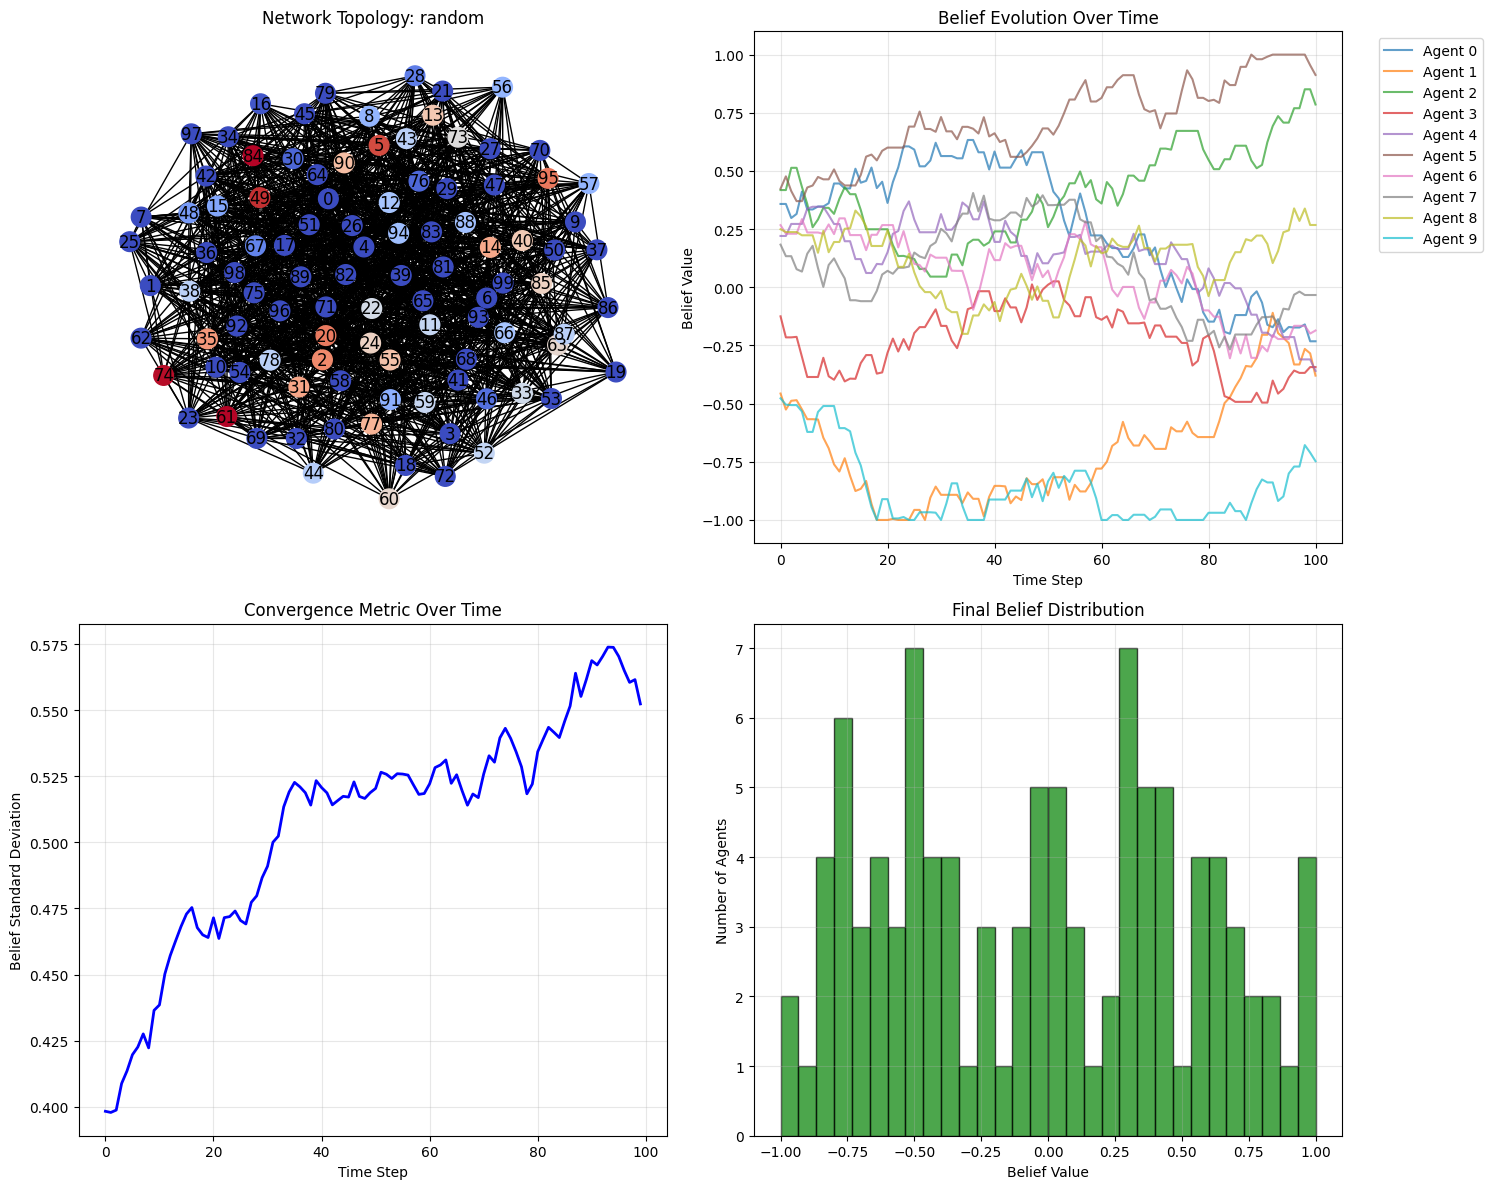

In [79]:
# Example 1: Random Network Simulation
async def run_random_network_example():
    """Example simulation with random network"""
    
    # Configure simulation
    sim = BeliefFormationSimulation(
        num_agents=100,
        topic="AI will significantly improve human life in the next decade",
        network_type=NetworkType.RANDOM,
        edge_probability=0.3
    )
    
    # Run simulation
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize results
    sim.visualize_results()
    
    return results

# Run the example
results = await run_random_network_example()

INFO:__main__:

Running simulation for lattice network...
INFO:__main__:Starting simulation with 100 agents on lattice network
INFO:__main__:Topic: Renewable energy should be the primary focus of energy policy
INFO:__main__:

Running simulation for random network...
INFO:__main__:Starting simulation with 100 agents on random network
INFO:__main__:Topic: Renewable energy should be the primary focus of energy policy
INFO:__main__:

Running simulation for fully_connected network...
INFO:__main__:Starting simulation with 100 agents on fully_connected network
INFO:__main__:Topic: Renewable energy should be the primary focus of energy policy
INFO:__main__:

Running simulation for small_world network...
INFO:__main__:Starting simulation with 100 agents on small_world network
INFO:__main__:Topic: Renewable energy should be the primary focus of energy policy


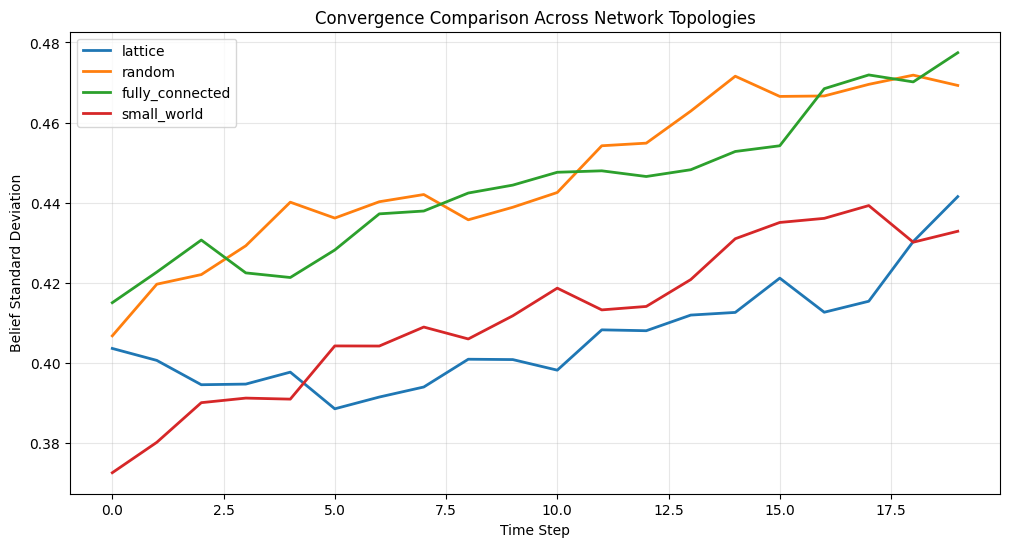


Summary of Results:
------------------------------------------------------------
Network Type         Final Std Dev   Final Mean Belief
------------------------------------------------------------
lattice              0.4415          -0.0560        
random               0.4693          0.0650         
fully_connected      0.4774          0.0087         
small_world          0.4329          0.0153         


In [80]:
# Example 2: Comparison of Different Network Topologies
async def compare_network_topologies():
    """Compare belief convergence across different network types"""
    
    topic = "Renewable energy should be the primary focus of energy policy"
    num_agents = 100
    num_steps = 20
    
    network_configs = [
        (NetworkType.LATTICE, {}),
        (NetworkType.RANDOM, {'edge_probability': 0.3}),
        (NetworkType.FULLY_CONNECTED, {}),
        (NetworkType.SMALL_WORLD, {'k': 4, 'p': 0.3}),
    ]
    
    results_comparison = {}
    
    for network_type, kwargs in network_configs:
        logger.info(f"\n\nRunning simulation for {network_type.value} network...")
        
        sim = BeliefFormationSimulation(
            num_agents=num_agents,
            topic=topic,
            network_type=network_type,
            **kwargs
        )
        
        results = await sim.run_full_simulation(
            num_steps=num_steps,
            interaction_rate=0.5,
            verbose=False
        )
        
        results_comparison[network_type.value] = {
            'convergence_metrics': results['convergence_metrics'],
            'final_std': results['convergence_metrics'][-1],
            'final_mean_belief': np.mean(list(results['final_beliefs'].values()))
        }
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    for network_name, data in results_comparison.items():
        plt.plot(data['convergence_metrics'], label=network_name, linewidth=2)
    
    plt.xlabel('Time Step')
    plt.ylabel('Belief Standard Deviation')
    plt.title('Convergence Comparison Across Network Topologies')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print summary
    print("\nSummary of Results:")
    print("-" * 60)
    print(f"{'Network Type':<20} {'Final Std Dev':<15} {'Final Mean Belief':<15}")
    print("-" * 60)
    for network_name, data in results_comparison.items():
        print(f"{network_name:<20} {data['final_std']:<15.4f} {data['final_mean_belief']:<15.4f}")
    
    return results_comparison

# Run the comparison
comparison_results = await compare_network_topologies()

Initial Network Structure:


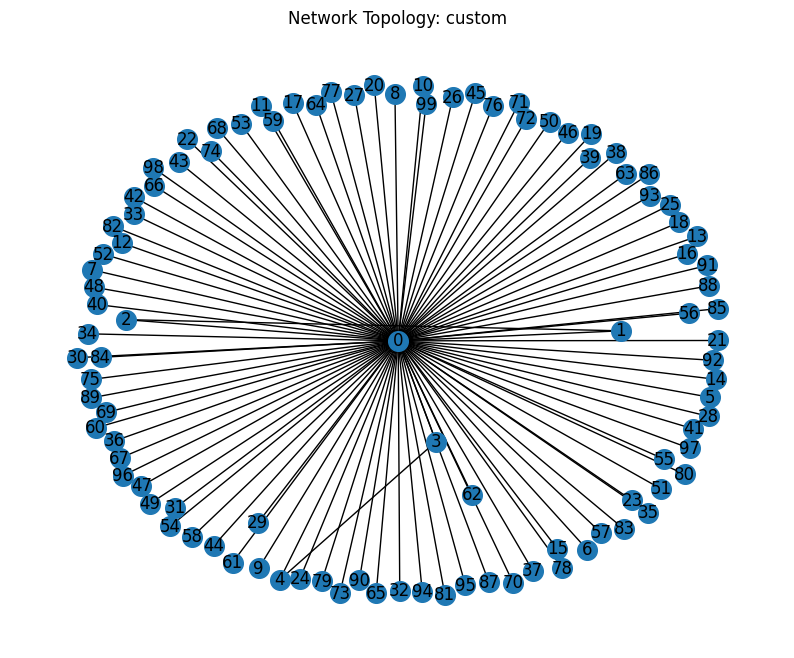

INFO:__main__:Starting simulation with 100 agents on custom network
INFO:__main__:Topic: Remote work is more productive than office work
INFO:__main__:
=== Step 1/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.3752
INFO:__main__:
=== Step 2/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.3781
INFO:__main__:
=== Step 3/100 ===
INFO:__main__:Conducted 2 parallel conversations
INFO:__main__:Convergence metric: 0.3761
INFO:__main__:
=== Step 4/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.3746
INFO:__main__:
=== Step 5/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.3757
INFO:__main__:
=== Step 6/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.3774
INFO:__main__:
=== Step 7/100 ===
INFO:__main__:Conducted 3 parallel conversations
INFO:__main__:Convergence metric: 0.

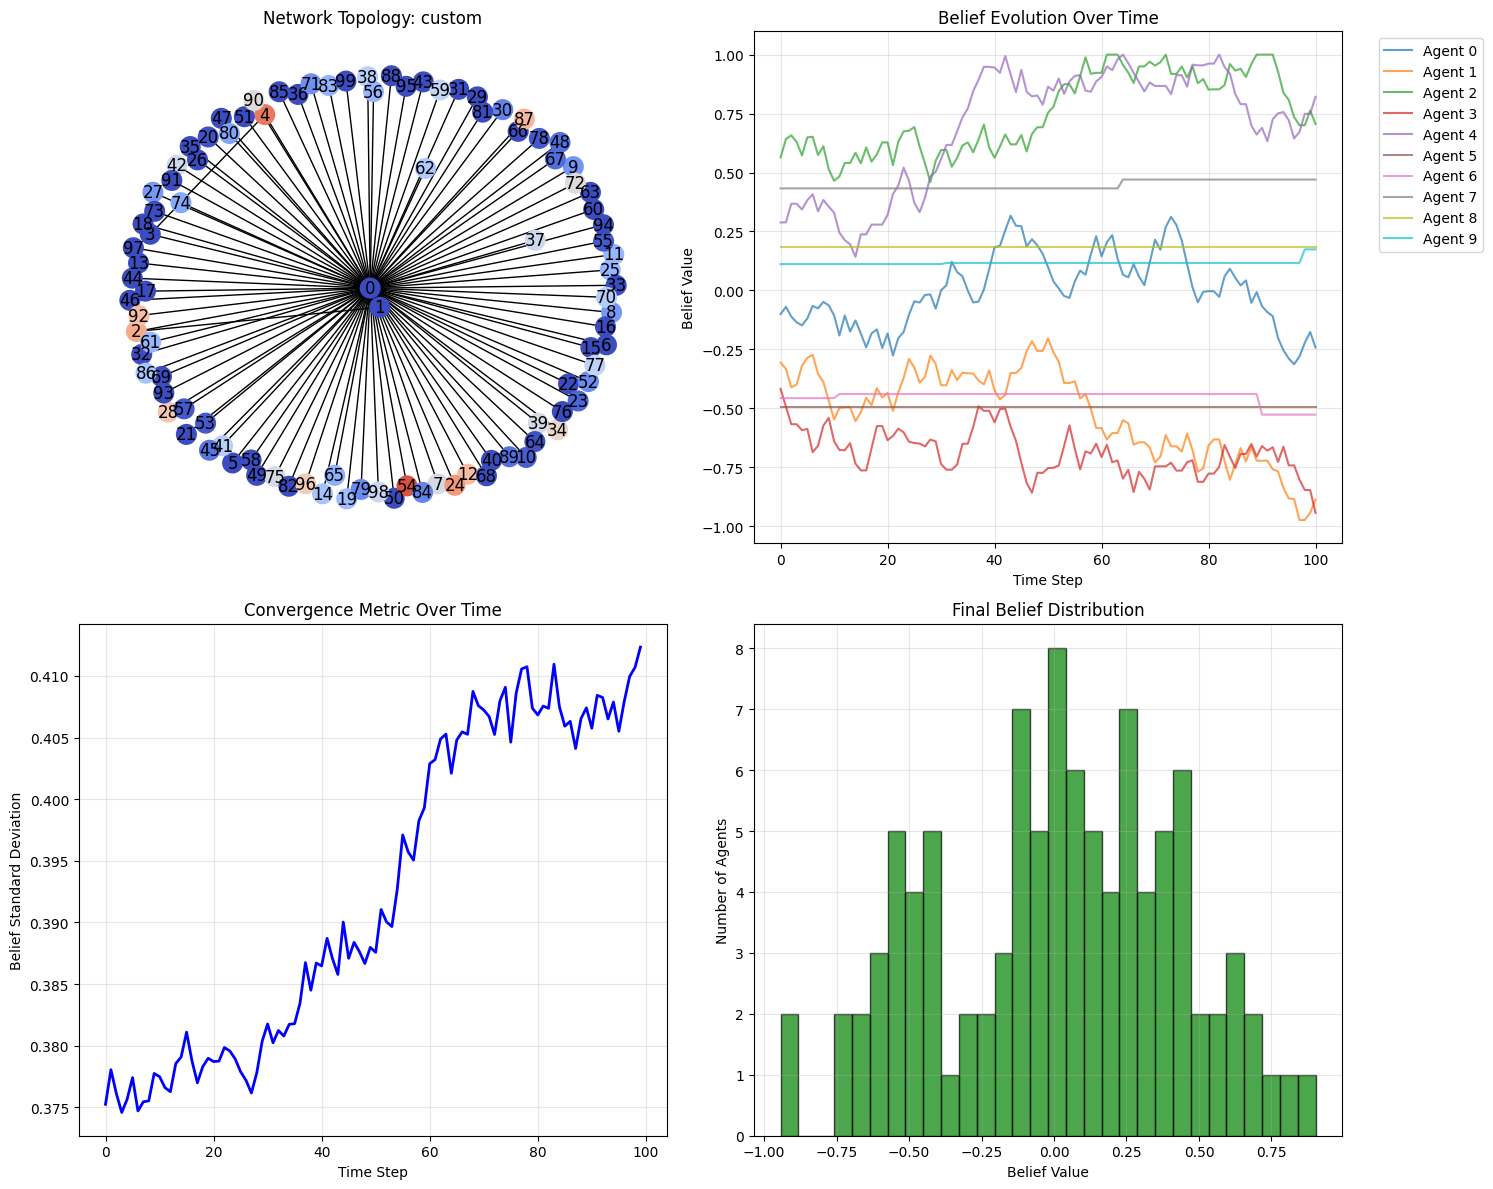

In [81]:
# Example 3: Custom Network from Adjacency Matrix
async def run_custom_network_example():
    """Example with custom network topology"""
    
    # Create a custom adjacency matrix (hub-and-spoke pattern)
    num_agents = 100
    adj_matrix = np.zeros((num_agents, num_agents))
    
    # Create hub-and-spoke: agent 0 is connected to all others
    for i in range(1, num_agents):
        adj_matrix[0, i] = 1
        adj_matrix[i, 0] = 1
    
    # Add a few additional connections
    adj_matrix[1, 2] = adj_matrix[2, 1] = 1
    adj_matrix[3, 4] = adj_matrix[4, 3] = 1
    
    # Create simulation
    sim = BeliefFormationSimulation(
        num_agents=num_agents,
        topic="Remote work is more productive than office work",
        network_type=NetworkType.CUSTOM,
        adjacency_matrix=adj_matrix
    )
    
    # Visualize initial network
    print("Initial Network Structure:")
    sim.network.visualize()
    
    # Run simulation
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.7,
        verbose=True
    )
    
    # Show final results
    sim.visualize_results()
    
    return results

# Run the custom network example
custom_results = await run_custom_network_example()

## Running the Simulation

To run the simulation with your own LLM:

1. Implement the `LLMInterface.generate_response()` method with your preferred LLM API
2. Configure the `LLMConfig` with your API credentials
3. Run any of the example simulations

The simulation supports:
- **Asynchronous conversations**: Multiple agent pairs can converse simultaneously
- **Prompt-based belief updates**: LLMs determine their own belief changes
- **Flexible network topologies**: Choose from lattice, random, fully connected, small-world, scale-free, or custom networks

INFO:__main__:Starting simulation with 100 agents on lattice network
INFO:__main__:Topic: Technology companies should be more heavily regulated
INFO:__main__:
=== Step 1/100 ===
INFO:__main__:Conducted 35 parallel conversations
INFO:__main__:Convergence metric: 0.3971
INFO:__main__:
=== Step 2/100 ===
INFO:__main__:Conducted 39 parallel conversations
INFO:__main__:Convergence metric: 0.3999
INFO:__main__:
=== Step 3/100 ===
INFO:__main__:Conducted 37 parallel conversations
INFO:__main__:Convergence metric: 0.4113
INFO:__main__:
=== Step 4/100 ===
INFO:__main__:Conducted 36 parallel conversations
INFO:__main__:Convergence metric: 0.4140
INFO:__main__:
=== Step 5/100 ===
INFO:__main__:Conducted 36 parallel conversations
INFO:__main__:Convergence metric: 0.4207
INFO:__main__:
=== Step 6/100 ===
INFO:__main__:Conducted 35 parallel conversations
INFO:__main__:Convergence metric: 0.4139
INFO:__main__:
=== Step 7/100 ===
INFO:__main__:Conducted 36 parallel conversations
INFO:__main__:Converge

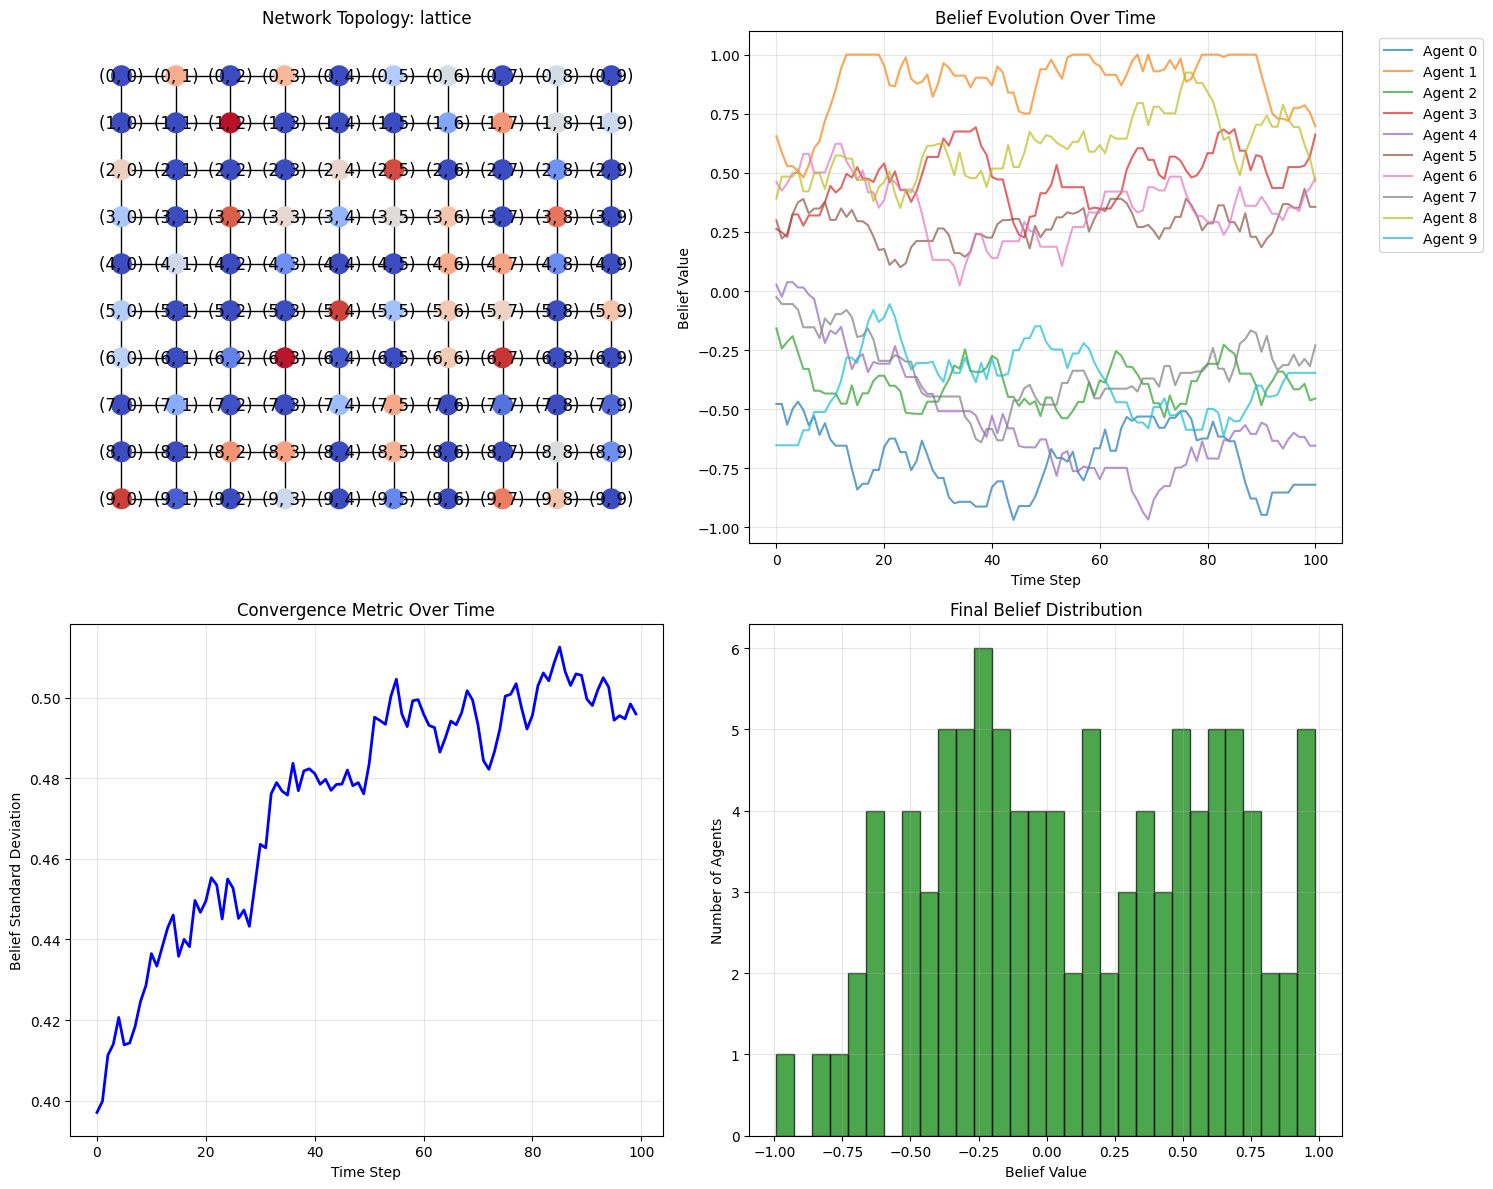


Simulation completed successfully!
Final convergence metric: 0.4959
Total conversations: 3650


In [82]:
# Quick start example
async def quick_start():
    """Quick start example to test the simulation"""
    
    # Create a simple simulation
    sim = BeliefFormationSimulation(
        num_agents=100,  # 10x10 grid for lattice
        topic="Technology companies should be more heavily regulated",
        network_type=NetworkType.LATTICE
    )
    
    # Run for just a few steps
    results = await sim.run_full_simulation(
        num_steps=steps,
        interaction_rate=0.5,
        verbose=True
    )
    
    # Visualize
    sim.visualize_results()
    
    print("\nSimulation completed successfully!")
    print(f"Final convergence metric: {results['convergence_metrics'][-1]:.4f}")
    print(f"Total conversations: {results['total_conversations']}")

# Uncomment to run:
await quick_start()